### Import and Settings

In [ ]:
#importing necessary libraries

import numpy as np
import utils
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
import random

In [ ]:
# Seed settings

def START_seed():
    seed = 7
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
START_seed()

In [3]:
data_file = 'data/plants_data.xlsx'
split = 0.8

### Data Pre Processing

In [ ]:
plant = 'Y' # Edit to choose which plant to run on [B, K, S, X Y]
processed = 'data/processed_' + plant.lower() + '.xlsx'
plant = 'Plant ' + plant.upper()

In [ ]:
df_ = pd.read_excel(data_file, sheet_name=plant, skiprows=1, nrows=1239)

# Remove unnecessary columns and rows
df_.drop(index=df_.index[0], inplace=True)
df_.drop(columns=['Date'], inplace=True)
df_.columns = df_.columns.str.strip()

rows, cols = df_.shape
reaction_rates = [col for col in df_.columns if " RR" in col]

print("Number of Columns:", cols, ", Number of Rows:", rows)

df_.head()

Number of Columns: 12 , Number of Rows: 1236


,Feed B,Feed S,Feed K,Feed i,Feed O,Feed N,C1 RR,C1,NGL RR,NGL,Sulphur RR,Sulphur
1,299,178,73,797,139,114,1.0,1211,0.95,9494,1.0,2658
2,299,183,69,758,139,134,1.0,1202,0.95,9687,1.0,2395
3,299,184,86,769,179,115,1.0,1198,0.95,9742,1.0,2344
4,299,186,69,749,199,117,1.0,1191,0.95,10048,1.0,2409
5,299,185,76,667,197,122,1.0,1185,0.95,10053,1.0,2311


In [6]:
# Give assumption of fully optimized outputs
for rate in reaction_rates:
    df_[rate[:-3]] = df_[rate[:-3]] / df_[rate]

In [7]:
cols = list(set(df_.columns) - set(reaction_rates))
df = df_.copy()

df = utils.rm_zeros(df, cols)
df = utils.rm_outliers(df, n_neighbors=5, contamination=0.01)

df = df[cols] * 1.0

for i in cols:
    df[i] = pd.to_numeric(df[i], errors='coerce')

In [8]:
df.to_excel(processed, index=False)

In [9]:
# Edit here to get models of different features and targets
# feeds = features
# prods = targets

feeds = [col for col in df.columns if "Feed" in col]
prods = list(set(df.columns) - set(feeds))
df_train = df.sample(frac=split, random_state=7)
df_test = df.drop(df_train.index)

### Regression Based Prediction

In [12]:
model, result = utils.evaluate_models(df, rows=prods, cols=feeds)

weights, biases = utils.parameter_extractor(model['Linear Regression'], prods)

===================== Results =====================
output Streams = C1, NGL, Sulphur
                          R2 Score            MSE        RMSE         MAE  \
Linear Regression         0.402799  377322.393320  614.265735  331.390547   
Decision Tree             0.332100  373772.508216  611.369371  305.599056   
Random Forest             0.614412  214948.303115  463.625175  230.431211   
Support Vector Regressor  0.061735  830995.837160  911.589731  486.458536   

                             CMAPE  
Linear Regression         0.911435  
Decision Tree             0.911323  
Random Forest             0.931919  
Support Vector Regressor  0.883715   

LinearRegression()
LinearRegression()
LinearRegression()


### Neural Network Based Prediction

In [ ]:
# Edit hyperparamters to try different outcomes

hidden_sizes = [3,4,8,16]
criterion = nn.MSELoss()
optimizer = optim.Adam
lr = 0.001
epochs = 2000
n_splits = 5

config = {
    "input"        : feeds,
    "hidden_sizes" : hidden_sizes,
    "output"       : prods,
    "df"           : df_train,
    "coefficients" : weights,
    "biases"       : biases,
    "lr"           : lr,
}


Fold 1/5
Epoch [200/2000], Training Loss: 369138.3750, Validation Loss: 273185.6875, CMAPE: 89.52%, R²: 0.9895
Epoch [400/2000], Training Loss: 368732.9062, Validation Loss: 272432.9062, CMAPE: 89.53%, R²: 0.9895
Epoch [600/2000], Training Loss: 368250.2500, Validation Loss: 271676.0312, CMAPE: 89.54%, R²: 0.9895
Epoch [800/2000], Training Loss: 367714.6875, Validation Loss: 270820.7812, CMAPE: 89.54%, R²: 0.9896
Epoch [1000/2000], Training Loss: 367156.4688, Validation Loss: 269910.0625, CMAPE: 89.55%, R²: 0.9896
Epoch [1200/2000], Training Loss: 366598.8438, Validation Loss: 268977.6875, CMAPE: 89.56%, R²: 0.9896
Epoch [1400/2000], Training Loss: 366058.3125, Validation Loss: 268049.4688, CMAPE: 89.57%, R²: 0.9897
Epoch [1600/2000], Training Loss: 365545.5000, Validation Loss: 267144.8125, CMAPE: 89.58%, R²: 0.9897
Epoch [1800/2000], Training Loss: 365063.9688, Validation Loss: 266274.7500, CMAPE: 89.60%, R²: 0.9897
Epoch [2000/2000], Training Loss: 364611.9062, Validation Loss: 265

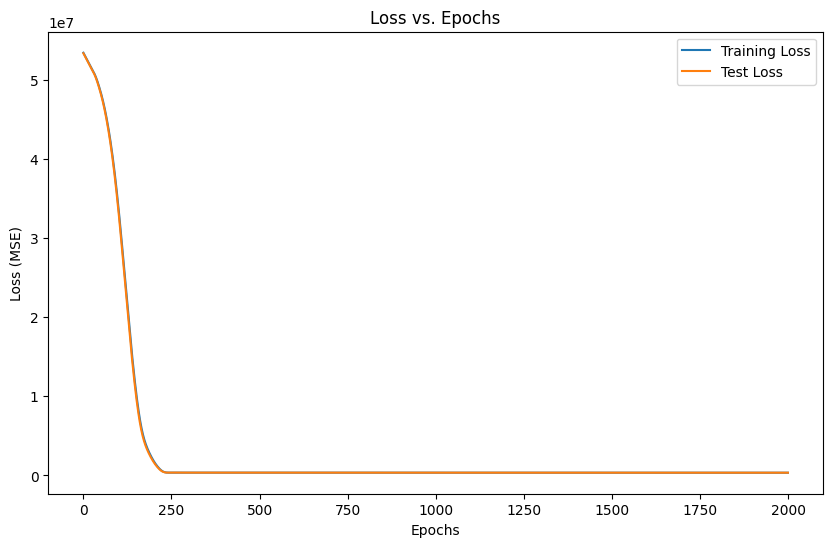

In [ ]:
# Train with cross validation

fnn = utils.makeNN(feeds, hidden_sizes, prods, df_train, coefficients=weights, biases=biases, lr=lr)

models, fold_results, trainLoss, valLoss = utils.trainKfolds(fnn, criterion, optimizer, epochs=epochs, n_splits=n_splits)
utils.loss_plot(trainLoss, valLoss)

### Yield Calculation and Evaluation

In [ ]:
# Edit to get more / less accurate yield calculations

constExp = [0,1000,2]
feedRangeBounds = [0,2000]

In [ ]:
yield_results, yield_std = utils.feedsYield(models, feeds, prods, multipleModels=1, constExp=constExp, feedRangeBounds=feedRangeBounds)
yield_results.head()


,NGL,Sulphur,C1
Feed i,1.920504,0.351603,0.170947
Feed B,5.414323,0.977239,0.477391
Feed S,5.763380,1.026102,0.503989
Feed K,-0.759325,-0.130454,-0.064188
Feed O,11.260004,2.016667,0.987769


In [ ]:
# Evaluate created models

pred = utils.ensemble_predict(models, torch.tensor(df_test[feeds].values, dtype=torch.float32))
test = df_test[prods].to_numpy()

MSE = mean_squared_error(test, pred)
CMAPE = 1 - np.mean(np.abs((test - pred) / test))

print(f'MSE: {MSE:.4f}, and CMAPE: {CMAPE:.4f}')

MSE: 335509.4263, and CMAPE: 0.8926


In [ ]:
# Empirical yields calculated in the lab, used as a baseline

theoretical = pd.DataFrame.from_dict({'Feed B': {'C1' : 0.72, 'NGL' : 7.80, 'Sulphur': 1.55},
                                      'Feed S': {'C1' : 0.84, 'NGL' : 2.00, 'Sulphur': 2.00},
                                      'Feed K': {'C1' : 0.70, 'NGL' : 9.47, 'Sulphur': 0.00},
                                      'Feed i': {'C1' : 0.84, 'NGL' : 2.49, 'Sulphur': 0.90},
                                      'Feed O': {'C1' : 0.50, 'NGL' : 23.4, 'Sulphur': 1.90},
                                      'Feed N': {'C1' : 0.80, 'NGL' : 6.67, 'Sulphur': 0.60}}).T

theoretical = theoretical[[col for col in theoretical.columns if col in prods]]
theoretical = theoretical.loc[[idx for idx in theoretical.index if idx in feeds]]

theoretical.head()

,C1,NGL,Sulphur
Feed B,0.72,7.80,1.55
Feed S,0.84,2.00,2.00
Feed K,0.70,9.47,0.00
Feed i,0.84,2.49,0.90
Feed O,0.50,23.40,1.90


In [ ]:
# Evaluation score of theoretical yields

pred_theo = df_test[feeds].dot(theoretical)

MSE = mean_squared_error(df_test[prods], pred_theo)
CMAPE = (1 - np.mean(np.abs((df_test[prods] - pred_theo) / df_test[prods]))) * 100

print(f'Theoretical yields prediction evaluation\n  MSE: {MSE:.4f}\nCMAPE: {CMAPE:.4f}%')

Theoretical yields prediction evaluation
  MSE: 63324809.1714
CMAPE: 82.6583%


In [ ]:
# Evaluation score of predicted yields

predNN = df_test[feeds].dot(yield_results) 

MSE = mean_squared_error(df_test[prods], predNN)
CMAPE = (1 - np.mean(np.abs((df_test[prods] - predNN) / df_test[prods]))) * 100

print(f'Model yields prediction evaluation\n  MSE: {MSE:.4f}\nCMAPE: {CMAPE:.4f}%')

Model yields prediction evaluation
  MSE: 5372694.2851
CMAPE: 69.6503%


### Model Saving

In [ ]:
save_path = 'saved_models/' + 'y_model.pth'

In [ ]:
torch.save({
    "models": [model.state_dict() for model in models],
    "config": [config for model in models]
}, save_path)

print(f"Models saved to {save_path}")

Models saved to saved_models/y_model.pth


# Plant Y:
## -------------------------------------------------------------------------

### Data Loading and Pre-processing

In [ ]:
# Uploading data and observing basic information
df_y = pd.read_excel(data_file, sheet_name='Plant Y', skiprows=1)

df_y.drop(index=df_y.index[0], inplace=True)
df_y.drop(columns=['Date'], inplace=True)

rows, cols = df_y.shape
reaction_rates = [col for col in df_y.columns if " RR" in col]

print("Number of Columns:", cols, ", Number of Rows:", rows)
df_y.head()

Number of Columns: 12 , Number of Rows: 1236


,Feed B,Feed S,Feed K,Feed i,Feed O,Feed N,C1 RR,C1,NGL RR,NGL,Sulphur RR,Sulphur
1,299,178,73,797,139,114,1.0,1211,0.95,9494,1.0,2658
2,299,183,69,758,139,134,1.0,1202,0.95,9687,1.0,2395
3,299,184,86,769,179,115,1.0,1198,0.95,9742,1.0,2344
4,299,186,69,749,199,117,1.0,1191,0.95,10048,1.0,2409
5,299,185,76,667,197,122,1.0,1185,0.95,10053,1.0,2311


In [ ]:
# Give assumption of fully optimized outputs
for rate in reaction_rates:
    df_y[rate[:-3]] = df_y[rate[:-3]] / df_y[rate]

In [ ]:
# data pre-processing
cols = list(set(df_y.columns) - set(reaction_rates))
df = df_y.copy()

df = utils.rm_zeros(df, cols)
df = utils.rm_outliers(df, n_neighbors=10, contamination=0.05)

df = df[cols] * 1.0

for i in cols:
    df[i] = pd.to_numeric(df[i], errors='coerce')

In [ ]:
df.to_excel('data/processed_y.xlsx', index=False)

In [ ]:
df.head()

,Feed i,Feed B,C1,Feed K,Feed O,Sulphur,Feed S,NGL,Feed N
1,797.0,299.0,1211.0,73.0,139.0,2658.0,178.0,9993.684211,114.0
2,758.0,299.0,1202.0,69.0,139.0,2395.0,183.0,10196.842105,134.0
3,769.0,299.0,1198.0,86.0,179.0,2344.0,184.0,10254.736842,115.0
4,749.0,299.0,1191.0,69.0,199.0,2409.0,186.0,10576.842105,117.0
5,667.0,299.0,1185.0,76.0,197.0,2311.0,185.0,10582.105263,122.0


### Predict with Regression

In [ ]:
cols = ['Feed B', 'Feed S','Feed K','Feed i','Feed O ','Feed N']
C1_models_y , C1_results_y = utils.evaluate_models(df,['C1'], cols)
NGL_models_y , NGL_results_y = utils.evaluate_models(df,['NGL'], cols)

cols = ['Feed B', 'Feed S','Feed i','Feed O ', 'Feed N']
Sulphur_models_y , Sulphur_results_y = utils.evaluate_models(df,['Sulphur'],cols)

===================== Results =====================
output Streams = C1
                          R2 Score          MSE       RMSE        MAE  \
Linear Regression         0.241330  6713.834163  81.937990  53.143880   
Decision Tree             0.403379  5279.789474  72.662160  39.730994   
Random Forest             0.535877  4107.248963  64.087822  32.782865   
Support Vector Regressor  0.114696  7834.483720  88.512619  53.508432   

                             CMAPE  
Linear Regression         0.945459  
Decision Tree             0.958964  
Random Forest             0.965050  
Support Vector Regressor  0.943918   

===================== Results =====================
output Streams = NGL
                          R2 Score           MSE         RMSE          MAE  \
Linear Regression         0.547594  1.010900e+06  1005.435290   682.437121   
Decision Tree             0.605846  8.807366e+05   938.475697   595.426285   
Random Forest             0.751119  5.561236e+05   745.736948   450.

In [ ]:
cols = ['Feed B', 'Feed S','Feed K','Feed i','Feed O ', 'Feed N']
out = ['C1', 'NGL', 'Sulphur']
all_models_y , all_results_y = utils.evaluate_models(df,out,cols)

===================== Results =====================
output Streams = C1, NGL, Sulphur
                          R2 Score            MSE        RMSE         MAE  \
Linear Regression         0.402799  377322.393320  614.265735  331.390547   
Decision Tree             0.386583  328619.951839  573.253828  299.041038   
Random Forest             0.610645  215137.440901  463.829107  229.572363   
Support Vector Regressor  0.061735  830995.837160  911.589731  486.458536   

                             CMAPE  
Linear Regression         0.911435  
Decision Tree             0.914561  
Random Forest             0.932641  
Support Vector Regressor  0.883715   



### Neural Network


Fold 1/5
Epoch [200/2000], Training Loss: 19939312.0000, Validation Loss: 19769678.0000, CMAPE: 60.99%, R²: 0.2501
Epoch [400/2000], Training Loss: 929873.3125, Validation Loss: 1194377.6250, CMAPE: 86.02%, R²: 0.9547
Epoch [600/2000], Training Loss: 815948.3125, Validation Loss: 1052435.2500, CMAPE: 86.24%, R²: 0.9601
Epoch [800/2000], Training Loss: 712011.1875, Validation Loss: 921027.2500, CMAPE: 86.41%, R²: 0.9651
Epoch [1000/2000], Training Loss: 625963.3750, Validation Loss: 810075.6250, CMAPE: 86.51%, R²: 0.9693
Epoch [1200/2000], Training Loss: 559963.0625, Validation Loss: 722847.6250, CMAPE: 86.53%, R²: 0.9726
Epoch [1400/2000], Training Loss: 512282.5625, Validation Loss: 658103.1250, CMAPE: 86.52%, R²: 0.9750
Epoch [1600/2000], Training Loss: 478982.4688, Validation Loss: 611913.1875, CMAPE: 86.51%, R²: 0.9768
Epoch [1800/2000], Training Loss: 455523.8750, Validation Loss: 579371.4375, CMAPE: 86.53%, R²: 0.9780
Epoch [2000/2000], Training Loss: 438035.4688, Validation Los

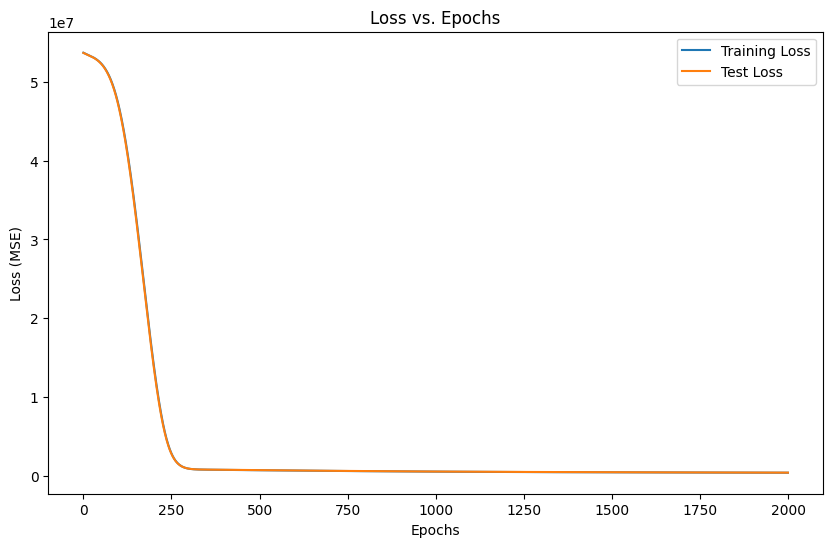

In [ ]:
input = ['Feed B', 'Feed S','Feed K','Feed i','Feed O ', 'Feed N']
output = ['C1', 'NGL', 'Sulphur']
hidden_sizes = [16,16]

fnn_y, criterion, optimizer = utils.makeNN(input, output, hidden_sizes,df)
models, fold_results, trainLoss, valLoss = utils.trainKfolds(fnn_y, criterion, optimizer, epochs=2000, n_splits=5)

utils.loss_plot(trainLoss, valLoss)

In [ ]:
coefficients_y, biases_y = utils.parameter_extractor(all_models_y['Linear Regression'],['C1','NGL', 'Sulphur'])

LinearRegression()
LinearRegression()
LinearRegression()



Fold 1/5
Epoch [200/2000], Training Loss: 323576.1875, Validation Loss: 459860.6562, CMAPE: 87.32%, R²: 0.9826
Epoch [400/2000], Training Loss: 321030.9375, Validation Loss: 451618.0312, CMAPE: 87.29%, R²: 0.9829
Epoch [600/2000], Training Loss: 320281.6562, Validation Loss: 450513.0625, CMAPE: 87.29%, R²: 0.9829
Epoch [800/2000], Training Loss: 319419.6562, Validation Loss: 449233.9062, CMAPE: 87.30%, R²: 0.9830
Epoch [1000/2000], Training Loss: 318479.1250, Validation Loss: 447829.7812, CMAPE: 87.31%, R²: 0.9830
Epoch [1200/2000], Training Loss: 317484.9375, Validation Loss: 446335.7500, CMAPE: 87.32%, R²: 0.9831
Epoch [1400/2000], Training Loss: 316453.0625, Validation Loss: 444777.5938, CMAPE: 87.34%, R²: 0.9831
Epoch [1600/2000], Training Loss: 315390.0938, Validation Loss: 443170.0000, CMAPE: 87.36%, R²: 0.9832
Epoch [1800/2000], Training Loss: 314291.9062, Validation Loss: 441513.7812, CMAPE: 87.40%, R²: 0.9833
Epoch [2000/2000], Training Loss: 313141.0938, Validation Loss: 439

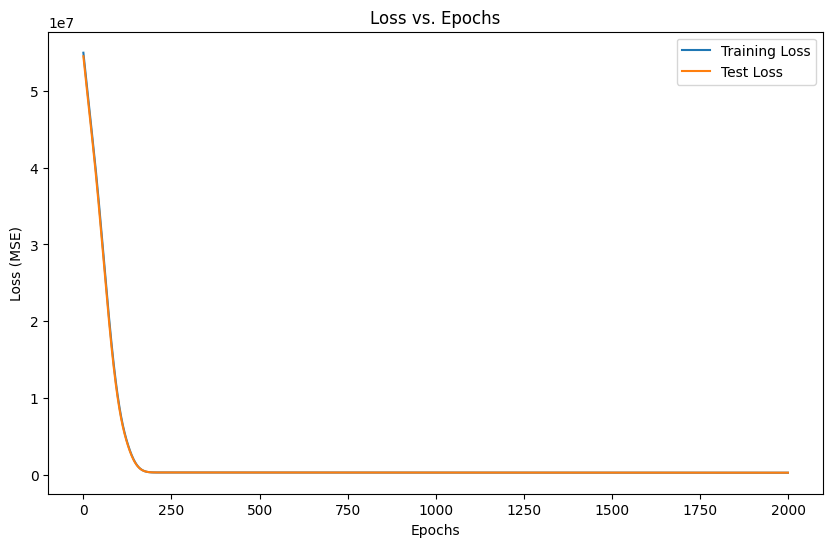

In [ ]:
input = ['Feed B', 'Feed S','Feed K','Feed i','Feed O ', 'Feed N']
output = ['C1', 'NGL', 'Sulphur']
hidden_sizes = [3,16,16]

fnn_y, criterion, optimizer = utils.makeNN(input, output, hidden_sizes,df,coefficients=coefficients_y , biases=biases_y)
models_s, fold_results_s, trainLoss_S, valLoss_S = utils.trainKfolds(fnn_y, criterion, optimizer, epochs=2000, n_splits=5)

utils.loss_plot(trainLoss_S, valLoss_S)


Fold 1/5
Epoch [200/2000], Training Loss: 911064.0000, Validation Loss: 1152272.0000, CMAPE: 84.56%, R²: 0.9563
Epoch [400/2000], Training Loss: 761698.5000, Validation Loss: 950723.7500, CMAPE: 85.20%, R²: 0.9639
Epoch [600/2000], Training Loss: 651540.1250, Validation Loss: 807131.8125, CMAPE: 85.31%, R²: 0.9694
Epoch [800/2000], Training Loss: 577005.1875, Validation Loss: 709102.2500, CMAPE: 85.39%, R²: 0.9731
Epoch [1000/2000], Training Loss: 526316.5000, Validation Loss: 644674.2500, CMAPE: 85.50%, R²: 0.9755
Epoch [1200/2000], Training Loss: 488444.3125, Validation Loss: 600408.8125, CMAPE: 85.65%, R²: 0.9772
Epoch [1400/2000], Training Loss: 458048.9375, Validation Loss: 568072.8125, CMAPE: 85.83%, R²: 0.9785
Epoch [1600/2000], Training Loss: 433369.5312, Validation Loss: 543592.3125, CMAPE: 86.01%, R²: 0.9794
Epoch [1800/2000], Training Loss: 413669.2188, Validation Loss: 524759.8750, CMAPE: 86.13%, R²: 0.9801
Epoch [2000/2000], Training Loss: 398238.6250, Validation Loss: 51

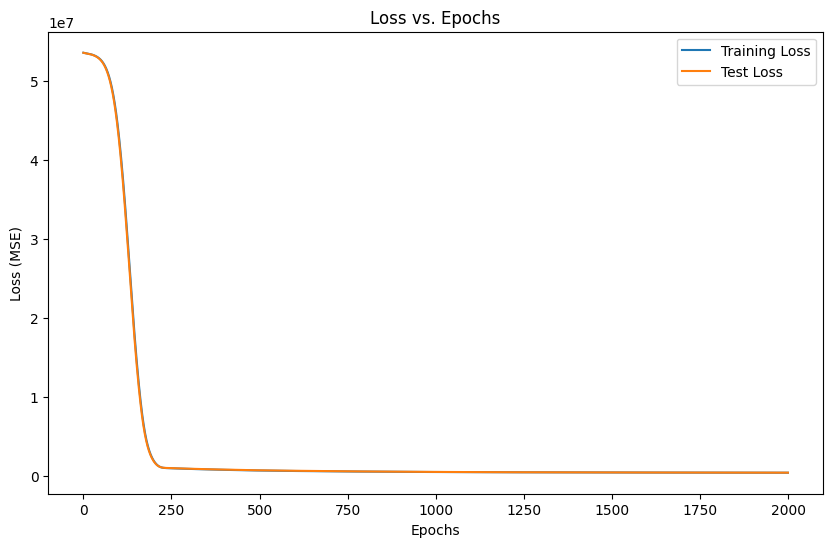

In [ ]:
input = ['Feed B', 'Feed S','Feed K','Feed i','Feed O ', 'Feed N']
output = ['C1', 'NGL', 'Sulphur']
hidden_sizes = [16,16,16]

fnn_y, criterion, optimizer = utils.makeNN(input, output, hidden_sizes,df)
models_c, fold_results_c, trainLoss_c, valLoss_c = utils.trainKfolds(fnn_y, criterion, optimizer, epochs=2000, n_splits=5)

utils.loss_plot(trainLoss_c, valLoss_c)


Fold 1/5
Epoch [200/2000], Training Loss: 35320008.0000, Validation Loss: 35132888.0000, CMAPE: 50.69%, R²: -0.3326
Epoch [400/2000], Training Loss: 11771830.0000, Validation Loss: 11699660.0000, CMAPE: 72.61%, R²: 0.5562
Epoch [600/2000], Training Loss: 1990206.0000, Validation Loss: 2120132.7500, CMAPE: 83.68%, R²: 0.9196
Epoch [800/2000], Training Loss: 903235.0000, Validation Loss: 1119565.6250, CMAPE: 85.31%, R²: 0.9575
Epoch [1000/2000], Training Loss: 837043.4375, Validation Loss: 1059178.1250, CMAPE: 85.42%, R²: 0.9598
Epoch [1200/2000], Training Loss: 795547.3125, Validation Loss: 1008254.5000, CMAPE: 85.56%, R²: 0.9618
Epoch [1400/2000], Training Loss: 753816.5625, Validation Loss: 955273.0000, CMAPE: 85.72%, R²: 0.9638
Epoch [1600/2000], Training Loss: 712707.2500, Validation Loss: 902670.4375, CMAPE: 85.88%, R²: 0.9658
Epoch [1800/2000], Training Loss: 673095.0625, Validation Loss: 851632.1875, CMAPE: 86.06%, R²: 0.9677
Epoch [2000/2000], Training Loss: 635653.4375, Valida

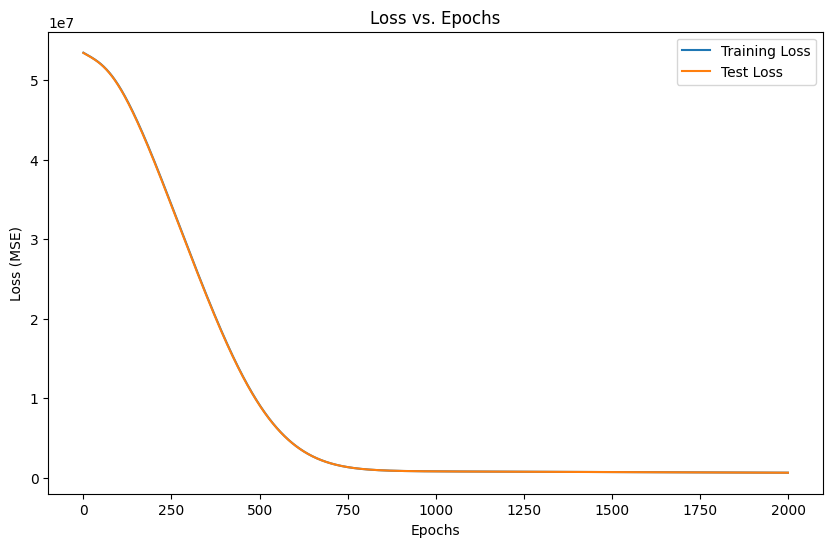

In [ ]:
input = ['Feed B', 'Feed S','Feed K','Feed i','Feed O ', 'Feed N']
output = ['C1', 'NGL', 'Sulphur']
hidden_sizes = [16]

fnn_y, criterion, optimizer = utils.makeNN(input, output, hidden_sizes, df)
models, fold_results, trainLoss, valLoss = utils.trainKfolds(fnn_y, criterion, optimizer, epochs=2000, n_splits=5)

utils.loss_plot(trainLoss, valLoss)

In [ ]:
# NOTE: set the fraction at start maybe
df_y_train = df.sample(frac=0.8, random_state=7)
df_y_test = df.drop(df_y_train.index)

In [ ]:
input = ['Feed B', 'Feed S','Feed K','Feed i','Feed O ', 'Feed N']
output = ['C1']
hidden_sizes = [16,16]

fnn_y, criterion, optimizer = utils.makeNN(input, output, hidden_sizes,df_y_train)
models_C1, fold_results_C1, trainLoss_C1, valLoss_C1 = utils.trainKfolds(fnn_y, criterion, optimizer, epochs=2000, n_splits=5)


Fold 1/5
Epoch [200/2000], Training Loss: 25375.8281, Validation Loss: 20050.5957, CMAPE: 89.00%, R²: -2.6538
Epoch [400/2000], Training Loss: 20980.2969, Validation Loss: 17135.3691, CMAPE: 89.78%, R²: -2.1226
Epoch [600/2000], Training Loss: 17862.4023, Validation Loss: 14841.7988, CMAPE: 90.63%, R²: -1.7046
Epoch [800/2000], Training Loss: 15796.9248, Validation Loss: 13035.2812, CMAPE: 91.49%, R²: -1.3754
Epoch [1000/2000], Training Loss: 14461.5381, Validation Loss: 11676.9717, CMAPE: 92.23%, R²: -1.1279
Epoch [1200/2000], Training Loss: 13608.5459, Validation Loss: 10728.5527, CMAPE: 92.79%, R²: -0.9551
Epoch [1400/2000], Training Loss: 13000.4102, Validation Loss: 10070.9502, CMAPE: 93.12%, R²: -0.8352
Epoch [1600/2000], Training Loss: 12482.5771, Validation Loss: 9545.0410, CMAPE: 93.33%, R²: -0.7394
Epoch [1800/2000], Training Loss: 11811.4932, Validation Loss: 8880.4453, CMAPE: 93.49%, R²: -0.6183
Epoch [2000/2000], Training Loss: 11511.2090, Validation Loss: 8591.8262, CMAP

In [ ]:
input = ['Feed B', 'Feed S','Feed K','Feed i','Feed O ', 'Feed N']
output = ['NGL']
hidden_sizes = [16,16]

fnn_y, criterion, optimizer = utils.makeNN(input, output, hidden_sizes,df_y_train)
models_NGL, fold_results_NGL, trainLoss_NGL, valLoss_NGL = utils.trainKfolds(fnn_y, criterion, optimizer, epochs=2000, n_splits=5)


Fold 1/5
Epoch [200/2000], Training Loss: 70827080.0000, Validation Loss: 69194192.0000, CMAPE: 33.53%, R²: -40.4272
Epoch [400/2000], Training Loss: 2670133.7500, Validation Loss: 2368648.7500, CMAPE: 89.50%, R²: -0.4181
Epoch [600/2000], Training Loss: 2283523.0000, Validation Loss: 2010287.1250, CMAPE: 90.35%, R²: -0.2036
Epoch [800/2000], Training Loss: 1940563.2500, Validation Loss: 1686984.0000, CMAPE: 91.16%, R²: -0.0100
Epoch [1000/2000], Training Loss: 1664664.8750, Validation Loss: 1420503.2500, CMAPE: 91.94%, R²: 0.1495
Epoch [1200/2000], Training Loss: 1459770.3750, Validation Loss: 1215720.1250, CMAPE: 92.61%, R²: 0.2721
Epoch [1400/2000], Training Loss: 1317504.8750, Validation Loss: 1066826.5000, CMAPE: 93.12%, R²: 0.3613
Epoch [1600/2000], Training Loss: 1222926.2500, Validation Loss: 962157.5000, CMAPE: 93.51%, R²: 0.4239
Epoch [1800/2000], Training Loss: 1159915.8750, Validation Loss: 888619.6250, CMAPE: 93.83%, R²: 0.4680
Epoch [2000/2000], Training Loss: 1115341.00

In [ ]:
input = ['Feed B', 'Feed S','Feed i','Feed O ', 'Feed N']
output = ['Sulphur']
hidden_sizes = [16,16]

fnn_y, criterion, optimizer = utils.makeNN(input, output, hidden_sizes,df_y_train)
models_Sulphur, fold_result_Sulphur, trainLoss_Sulphur, valLoss_Sulphur = utils.trainKfolds(fnn_y, criterion, optimizer, epochs=2000, n_splits=5)


Fold 1/5
Epoch [200/2000], Training Loss: 157826.0000, Validation Loss: 139797.8438, CMAPE: 86.14%, R²: 0.0998
Epoch [400/2000], Training Loss: 139512.7656, Validation Loss: 128299.5625, CMAPE: 86.78%, R²: 0.1738
Epoch [600/2000], Training Loss: 129818.0938, Validation Loss: 124351.7109, CMAPE: 87.07%, R²: 0.1992
Epoch [800/2000], Training Loss: 125300.9219, Validation Loss: 124136.7891, CMAPE: 87.18%, R²: 0.2006
Epoch [1000/2000], Training Loss: 123747.9141, Validation Loss: 125247.9141, CMAPE: 87.16%, R²: 0.1935
Epoch [1200/2000], Training Loss: 123266.5781, Validation Loss: 126098.3906, CMAPE: 87.13%, R²: 0.1880
Epoch [1400/2000], Training Loss: 123057.9609, Validation Loss: 126443.7812, CMAPE: 87.12%, R²: 0.1858
Epoch [1600/2000], Training Loss: 122930.6953, Validation Loss: 126494.9453, CMAPE: 87.12%, R²: 0.1854
Epoch [1800/2000], Training Loss: 122812.3672, Validation Loss: 126401.0078, CMAPE: 87.12%, R²: 0.1860
Epoch [2000/2000], Training Loss: 122703.5469, Validation Loss: 126

In [ ]:
input = ['Feed B', 'Feed S','Feed K','Feed i','Feed O ', 'Feed N']
output = ['C1', 'NGL', 'Sulphur']
hidden_sizes = [16,16]

fnn_y, criterion, optimizer = utils.makeNN(input, output, hidden_sizes, df_y_train)
models_all, fold_results_all, trainLoss_all, valLoss_all = utils.trainKfolds(fnn_y, criterion, optimizer, epochs=2000, n_splits=5)


Fold 1/5
Epoch [200/2000], Training Loss: 27452918.0000, Validation Loss: 27005068.0000, CMAPE: 57.35%, R²: -0.0415
Epoch [400/2000], Training Loss: 1129477.6250, Validation Loss: 985886.0625, CMAPE: 87.28%, R²: 0.9620
Epoch [600/2000], Training Loss: 974976.5000, Validation Loss: 848888.1250, CMAPE: 87.59%, R²: 0.9673
Epoch [800/2000], Training Loss: 835767.1875, Validation Loss: 724338.4375, CMAPE: 87.83%, R²: 0.9721
Epoch [1000/2000], Training Loss: 722447.8750, Validation Loss: 621002.2500, CMAPE: 88.00%, R²: 0.9760
Epoch [1200/2000], Training Loss: 637519.1875, Validation Loss: 541331.1875, CMAPE: 88.06%, R²: 0.9791
Epoch [1400/2000], Training Loss: 577667.1250, Validation Loss: 482932.9688, CMAPE: 88.10%, R²: 0.9814
Epoch [1600/2000], Training Loss: 536333.6875, Validation Loss: 440711.1875, CMAPE: 88.18%, R²: 0.9830
Epoch [1800/2000], Training Loss: 506645.3438, Validation Loss: 409235.8125, CMAPE: 88.30%, R²: 0.9842
Epoch [2000/2000], Training Loss: 483526.0312, Validation Los

In [ ]:
input = ['Feed B', 'Feed S','Feed K','Feed i','Feed O ', 'Feed N']
output = ['C1', 'NGL', 'Sulphur']
y_pred = utils.ensemble_predict(models_all, torch.tensor(df_y_test[input].values, dtype=torch.float32))
y_test = df_y_test[output].to_numpy()

MSE = mean_squared_error(y_test, y_pred)
MAP = 1 - np.mean(np.abs((y_test - y_pred) / y_test))

print(f'MSE: {MSE:.4f}, and CMAPE: {MAP:.4f}')

MSE: 444019.7136, and CMAPE: 0.8839


In [ ]:
input = ['Feed B', 'Feed S','Feed K','Feed i','Feed O ', 'Feed N']
output = ['C1']
y_pred = utils.ensemble_predict(models_C1, torch.tensor(df_y_test[input].values, dtype=torch.float32))
y_test = df_y_test[output].to_numpy()

MSE = mean_squared_error(y_test, y_pred)
MAP = 1 - np.mean(np.abs((y_test - y_pred) / y_test))

print(f'MSE: {MSE:.4f}, and CMAPE: {MAP:.4f}')

MSE: 9588.7051, and CMAPE: 0.9307


In [ ]:
input = ['Feed B', 'Feed S','Feed K','Feed i','Feed O ', 'Feed N']
output = ['NGL']
y_pred = utils.ensemble_predict(models_NGL, torch.tensor(df_y_test[input].values, dtype=torch.float32))
y_test = df_y_test[output].to_numpy()

MSE = mean_squared_error(y_test, y_pred)
MAP = 1 - np.mean(np.abs((y_test - y_pred) / y_test))

print(f'MSE: {MSE:.4f}, and CMAPE: {MAP:.4f}')

MSE: 1013524.2719, and CMAPE: 0.9348


In [ ]:
input = ['Feed B', 'Feed S','Feed i','Feed O ', 'Feed N']
output = ['Sulphur']
y_pred = utils.ensemble_predict(models_Sulphur, torch.tensor(df_y_test[input].values, dtype=torch.float32))
y_test = df_y_test[output].to_numpy()

MSE = mean_squared_error(y_test, y_pred)
MAP = 1 - np.mean(np.abs((y_test - y_pred) / y_test))

print(f'MSE: {MSE:.4f}, and CMAPE: {MAP:.4f}')

MSE: 136790.6171, and CMAPE: 0.8606


In [ ]:
inputs = ['Feed B', 'Feed S','Feed K','Feed i','Feed O ', 'Feed N']
output = ['C1', 'NGL', 'Sulphur']
# calculated theoritical yields: 

                    #   C1   NGL Sulphur
yieldsTheo = pd.DataFrame([[0.72, 7.80, 1.55], #B
                      [0.84, 2.00, 2.00], #S
                      [0.70, 9.47, 0.00], #K
                      [0.84, 2.49, 0.90], #i
                      [0.50, 23.4, 1.90], #O
                      [0.80, 6.67, 0.60]], #N
             columns=output, index=inputs) 

In [ ]:
# fcartion of the entire df_y ins+outs (dataFrame)
# df_y_train
# df_y_test

input = ['Feed B', 'Feed S','Feed K','Feed i','Feed O ', 'Feed N']
output = ['C1', 'NGL', 'Sulphur']
df_y_test_in = df_y_test[input]
df_y_test_out = df_y_test[output]

In [ ]:
predTheo = df_y_test_in.dot(yieldsTheo)

In [ ]:
MSE = mean_squared_error(df_y_test_out, predTheo)
MAP = 1 - np.mean(np.abs((df_y_test_out - predTheo) / df_y_test_out))

print(f'MSE: {MSE:.4f}, and CMAPE: {MAP:.4f}')

MSE: 2379365.9523, and CMAPE: 0.8266


In [ ]:
# NOTE: the model used should not be trained on the fractioned test data, to be changed
cols = ['Feed B', 'Feed S','Feed K','Feed i','Feed O ', 'Feed N']
rows = ['C1', 'NGL', 'Sulphur']
yield_results, yield_std = utils.feedsYield (models_c, cols, rows, multipleModels = 1, constExp = [0,1000,2], feedRangeBounds = [0, 2000])
yield_results = yield_results.T

In [ ]:
yield_results.head(6)

,C1,NGL,Sulphur
Feed B,0.838667,9.742172,1.693770
Feed S,0.730359,8.563973,1.445736
Feed K,0.064128,0.368747,0.142200
Feed i,0.376925,3.874637,0.788868
Feed O,1.161026,13.979962,2.355230
Feed N,1.056200,13.122900,2.158700


In [ ]:
yield_std.head(6)

,Feed B,Feed S,Feed K,Feed i,Feed O,Feed N
C1,0.002717,0.010375,0.023198,0.013750,0.018134,0.037601
NGL,0.024322,0.135273,0.319450,0.231123,0.325665,0.733390
Sulphur,0.006040,0.021199,0.042943,0.025916,0.036386,0.074001


In [ ]:
predNN = df_y_test_in.dot(yield_results) 
MSE = mean_squared_error(df_y_test_out, predNN)
MAP = 1 - np.mean(np.abs((df_y_test_out -predNN) / df_y_test_out))

print(f'MSE: {MSE:.4f}, and MAP: {MAP:.4f}')

MSE: 485341.6761, and MAP: 0.8785


In [ ]:
cols = ['Feed B', 'Feed S','Feed K','Feed i','Feed O ', 'Feed N']
rows = ['C1']
yield_results_C1, yield_std_C1 = utils.feedsYield (models_C1, cols, rows, multipleModels = 1, constExp = [0,1000,2], feedRangeBounds = [0, 2000])
yield_results_C1 = yield_results_C1.T

In [ ]:
cols = ['Feed B', 'Feed S','Feed K','Feed i','Feed O ', 'Feed N']
rows = ['NGL']
yield_results_NGL, yield_std_NGL = utils.feedsYield (models_NGL, cols, rows, multipleModels = 1, constExp = [0,1000,2], feedRangeBounds = [0, 2000])
yield_results_NGL = yield_results_NGL.T

In [275]:
cols = ['Feed B', 'Feed S','Feed i','Feed O ', 'Feed N']
rows = ['Sulphur']
yield_results_Sulphur, yield_std_Sulphur = utils.feedsYield (models_Sulphur, cols, rows, multipleModels = 1, constExp = [0,1000,2], feedRangeBounds = [0, 2000])
yield_results_Sulphur = yield_results_Sulphur.T
yield_results_Sulphur.loc['Feed K'] = 0
yield_std_Sulphur['Feed K'] = -1

NameError: name 'models_Sulphur' is not defined

In [ ]:
yield_new = pd.concat([yield_results_C1, yield_results_NGL, yield_results_Sulphur], axis=1)
yield_new.head(6)

,C1,NGL,Sulphur
Feed B,1.065880,9.672509,2.574972
Feed S,0.172588,8.975928,0.149176
Feed K,0.161296,1.921696,0.000000
Feed i,0.481714,3.413923,1.259542
Feed O,1.243236,12.458568,2.214764
Feed N,1.537414,12.127003,1.596944


In [ ]:
yield_std_new = pd.concat([yield_std_C1, yield_std_NGL, yield_std_Sulphur], axis=0).T
yield_std_new.head(6)

,C1,NGL,Sulphur
Feed B,0.043397,0.023139,0.222975
Feed S,0.040392,0.000944,0.234012
Feed K,0.029959,0.325145,-1.000000
Feed i,0.006155,0.229994,0.090812
Feed O,0.007445,0.001754,0.089037
Feed N,0.007476,0.008382,0.069186


In [ ]:
predNN_new = df_y_test_in.dot(yield_new) 
MSE = mean_squared_error(df_y_test_out, predNN_new)
MAP = 1 - np.mean(np.abs((df_y_test_out - predNN_new) / df_y_test_out))

print(f'MSE: {MSE:.4f}, and CMAPE: {MAP:.4f}')

MSE: 389590.6421, and CMAPE: 0.9051
